In [2]:
import os
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy.stats import norm
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from model_script.script_XGBoost_model_polars import DataCleaner, FeatureCreator, AnomalyFilter, WeightedPOICountsTransformer, data_loader, build_xgboost_model,save_model,plot_train_test_predictions


In [5]:
YEARS = ["2019","2020", "2021", "2022", "2023","2024"]
PREPROCESSED_FILE = "data_processed/data_dvf_preprocessed_test_explicabilite_IDF.csv"
BATCH_SIZE = 100_000
dep = ["75", "77", "78", "91", "92", "93", "94", "95"]

print("Starting preprocessing by year...")
# Charger la grille pour le pipeline
df_grid = pl.read_csv('data_pop_density/dataframe_densite&amenities_radius=500.csv')

# Définir le pipeline de preprocessing
pipeline_preprocess = Pipeline(steps=[
    ("cleaner", DataCleaner(nombre_lots_max=5, cutoff_valeur_fonciere_min=0.75e5, min_surface=15)),
    ("feature_creator", FeatureCreator(cutoff_prix_m2_min=3e3,cutoff_prix_m2_max=18e3)),
    ('weighted_poi', WeightedPOICountsTransformer(n_neighbors=4)),
    ("anomaly_filter", AnomalyFilter(contamination=0.1, target_elimination=True)),
    # ('weighted_poi', WeightedPOICountsTransformer(n_neighbors=4)),
])

pipeline_preprocess.set_params(weighted_poi__df_grid=df_grid)

with open(PREPROCESSED_FILE, "w") as f:
    pass

# === 1. Charger et prétraiter chaque année séparément ===
for year in YEARS:
    print(f"Processing year {year}...")

    # Charger les données de l'année en cours
    df_year = data_loader('data_dvf', annees=[year],departements=dep)
    print(f"Data loaded for {year}: {df_year.shape[0]} rows")

    # Appliquer le préprocessing
    df_processed = pipeline_preprocess.fit_transform(df_year)
    df_processed.drop_nulls()
    print(f"Data processed for {year}: {df_processed.shape[0]} rows")

    # Sauvegarder les données prétraitées en ajoutant au CSV
    with open(PREPROCESSED_FILE, mode="a") as f:
        df_processed.write_csv(f,include_header=True)

print("All years processed and saved!")

Starting preprocessing by year...
Processing year 2019...
Data loaded for 2019: 274317 rows
Shape before filtering: (274317, 15)
Shape after filtering: (167664, 15)
Data processed for 2019: 56350 rows
Processing year 2020...
Data loaded for 2020: 437750 rows
Shape before filtering: (437750, 15)
Shape after filtering: (256146, 15)
Data processed for 2020: 93476 rows
Processing year 2021...
Data loaded for 2021: 544775 rows
Shape before filtering: (544775, 15)
Shape after filtering: (345787, 15)
Data processed for 2021: 106338 rows
Processing year 2022...
Data loaded for 2022: 560673 rows
Shape before filtering: (560673, 15)
Shape after filtering: (356939, 15)
Data processed for 2022: 107168 rows
Processing year 2023...
Data loaded for 2023: 450368 rows
Shape before filtering: (450368, 15)
Shape after filtering: (271343, 15)
Data processed for 2023: 77739 rows
Processing year 2024...
Data loaded for 2024: 185731 rows
Shape before filtering: (185731, 15)
Shape after filtering: (115689, 15

In [6]:
df_lazy = pl.scan_csv(
            PREPROCESSED_FILE,
            has_header = True,
            schema_overrides={
                'surface_reelle_bati': pl.Float32,
                'type_local': pl.Utf8,  # Optimisation mémoire
                'year': pl.Int32,  # Réduction mémoire
                'sin_month': pl.Float32,
                'cos_month': pl.Float32,
                'nombre_lots': pl.Float32,
                'total_surface_carrez': pl.Float32,
                'lot1_surface_carrez': pl.Float32,
                'lot2_surface_carrez': pl.Float32,
                'lot3_surface_carrez': pl.Float32,
                'lot4_surface_carrez': pl.Float32,
                'lot5_surface_carrez': pl.Float32,
                'nombre_pieces_principales': pl.Float32,
                'surface_terrain': pl.Float32,
                'longitude': pl.Float32,
                'latitude': pl.Float32,
                'valeur_fonciere': pl.Float64,
                'densite_weighted': pl.Float32,
                'transport_pois_weighted': pl.Float32,
                'education_pois_weighted': pl.Float32,
                'health_pois_weighted': pl.Float32,
                'food_pois_weighted': pl.Float32,
                'shopping_pois_weighted': pl.Float32,
                'park_pois_weighted': pl.Float32,
                'entertainment_pois_weighted': pl.Float32,
                'cultural_pois_weighted': pl.Float32
            },
            ignore_errors = True
        ).drop_nulls()


# === 3. Séparation Train / Test (Lazy) ===
df = df_lazy.collect().sample(fraction=1.0,shuffle=True) # Convertit en DataFrame
df = df.with_columns(pl.lit(np.random.rand(len(df))).alias("split"))  # Ajoute une colonne random
df_lazy = df.lazy()  # Reconvertit en LazyFrame# Ajoute une colonne random
df_train = df_lazy.filter(pl.col("split") < 0.8).drop("split")  # 80% pour l'entraînement
df_test = df_lazy.filter(pl.col("split") >= 0.8).drop("split")  # 20% pour le test

df_train_features = df_train.drop("valeur_fonciere")
df_train_target = df_train.select("valeur_fonciere")
print(df_train_features.collect().shape)

df_test_features = df_test.drop("valeur_fonciere")
df_test_target = df_test.select("valeur_fonciere")
print(df_test_features.collect().shape)


# === 4. Pipeline d'encodage ===
categorical_columns_onehot = ['type_local']
numerical_columns = [
    'surface_reelle_bati', 'year', 'sin_month', 'cos_month', 'nombre_lots',
    'total_surface_carrez', 'lot1_surface_carrez', 'lot2_surface_carrez',
    'lot3_surface_carrez', 'lot4_surface_carrez', 'lot5_surface_carrez',
    'nombre_pieces_principales', 'surface_terrain', 'longitude', 'latitude',
    'densite_weighted', 'transport_pois_weighted', 'education_pois_weighted',
    'health_pois_weighted', 'food_pois_weighted', 'shopping_pois_weighted',
    'park_pois_weighted', 'entertainment_pois_weighted', 'cultural_pois_weighted'
]
unique_categories = [df_lazy.select(col).drop_nulls().unique().collect().to_series().to_list()
for col in categorical_columns_onehot]
# Créer les catégories pour OneHotEncoder
# === 5. Entraînement du modèle ===
print('Fitting du modèle :')
params = {
"objective": "reg:squarederror",  # Régression avec erreur quadratique
"learning_rate": 0.5,            # Plus bas = plus précis mais plus lent
"max_depth": 10,                  # Profondeur des arbres (trop élevé = overfitting)
"n_jobs": 2,                      # Nombre de threads utilisés
"subsample": 0.8,                 # Échantillonnage aléatoire pour éviter l'overfitting
"gamma": 0.1,                     # Prune les arbres faibles (réduction de l'overfitting)
"min_child_weight": 10,           # Empêche d'ajouter des feuilles inutiles
"lambda": 1,                     # Régularisation L2 (Ridge)
"alpha": 0.5                      # Régularisation L1 (Lasso)
}

column_transformer, xgb_model = build_xgboost_model(params, numerical_columns, categorical_columns_onehot, unique_categories )

def batch_generator(features_lazy, target_lazy, batch_size, params, column_transformer,xgb_model=None):
    """
    Génère des lots (batches) et ajuste le modèle XGBoost sur chaque batch, avec transformation des données.

    Parameters:
    - xgb_model: Le modèle XGBoost qui sera ajusté sur chaque batch
    - features_lazy: LazyFrame des features
    - target_lazy: LazyFrame de la cible (target)
    - batch_size: Taille du batch
    - params: Paramètres de XGBoost
    - column_transformer: Transformer qui s'occupe de l'encodage et de la mise à l'échelle des données

    Yields:
    - xgb_model: Le modèle ajusté après le batch
    """
    # Collecte des données sous forme de DataFrame en mémoire
    df_features = features_lazy.collect()
    df_target = target_lazy.collect()
    print("df_features.shape = ",df_features.shape)
    # Calcul du nombre de batches
    num_batches = len(df_features) // batch_size
    if len(df_features) % batch_size != 0:
        num_batches += 1

    print('num batches =',num_batches)

    # Générer les batches et ajuster le modèle
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(df_features))

        # Sélectionner un batch de données
        X_train_batch = df_features[start_idx:end_idx]
        y_train_batch = df_target[start_idx:end_idx].to_numpy().ravel()  # Flatten en vecteur 1D

        # Appliquer la transformation du pipeline (OneHot et Scaling)
        X_train_batch_transformed = column_transformer.fit_transform(X_train_batch)
        # Convertir en DMatrix et entraîner le modèle XGBoost
        dtrain = xgb.DMatrix(X_train_batch_transformed, label=y_train_batch)
        # Entraîner le modèle XGBoost
        if xgb_model is None:
            xgb_model = xgb.train(params, dtrain, num_boost_round=10)
        else:
            xgb_model = xgb.train(params, dtrain, num_boost_round=10, xgb_model=xgb_model)

        yield xgb_model

# Exemple d'utilisation dans votre boucle d'entraînement
for xgb_model in batch_generator(df_train_features, df_train_target, BATCH_SIZE, params, column_transformer):
    # Vous pouvez faire d'autres opérations avec xgb_model après chaque batch, si nécessaire
    pass

print("✅ Entraînement terminé !")

# === 7. Visualisation des prédictions ===
df_test_features_transformed = column_transformer.transform(df_test_features.collect())

# 2. Convertir les données de test en DMatrix
dtest = xgb.DMatrix(df_test_features_transformed)

# 3. Effectuer les prédictions sur les données de test
y_pred_test = xgb_model.predict(dtest)

# 4. Extraire les valeurs réelles (target) de df_test_target
y_test = df_test_target.collect().to_numpy().ravel()

(377089, 25)
(94532, 25)
Fitting du modèle :
df_features.shape =  (377089, 25)
num batches = 4


/home/phdel/.pyenv/versions/3.10.6/envs/upfund_dvf/lib/python3.10/site-packages/xgboost/core.py:723: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


✅ Entraînement terminé !


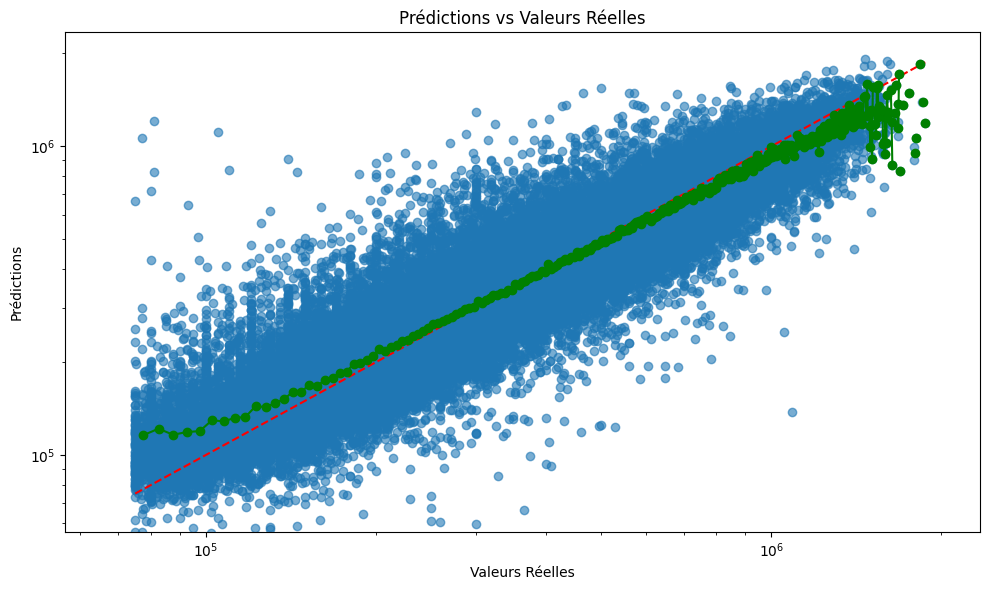

In [8]:
# 5. Plot : Comparaison des valeurs réelles et des prédictions
dx = 5000  # Taille des intervalles (ajuste selon l'échelle de tes données)

# Tri des données
bins = np.arange(min(y_test), max(y_test) + dx, dx)
bin_centers = bins[:-1] + dx / 2  # Centres des intervalles
mean_predictions = [np.mean(y_pred_test[(y_test >= bins[i]) & (y_test < bins[i+1])])
                    for i in range(len(bins)-1)]

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Ligne idéale
plt.plot(bin_centers, mean_predictions, color='green', linestyle='-', marker='o',
        label="Moyenne par intervalle")
plt.title("Prédictions vs Valeurs Réelles")
plt.xlabel("Valeurs Réelles")
plt.ylabel("Prédictions")
plt.xscale("log")
plt.yscale("log")
plt.xlim(0.75*min(y_test),1.25*max(y_test))
plt.ylim(0.75*min(y_test),1.25*max(y_test))
plt.tight_layout()


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.99540526,  0.6829774 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.14464367, -0.36874573],
       [ 0.        ,  0.        ,  1.        , ...,  0.        ,
         2.07096246,  0.04706112],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.14464367, -0.36874573],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         2.97656643,  0.4123913 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.15485725, -0.36874573]])

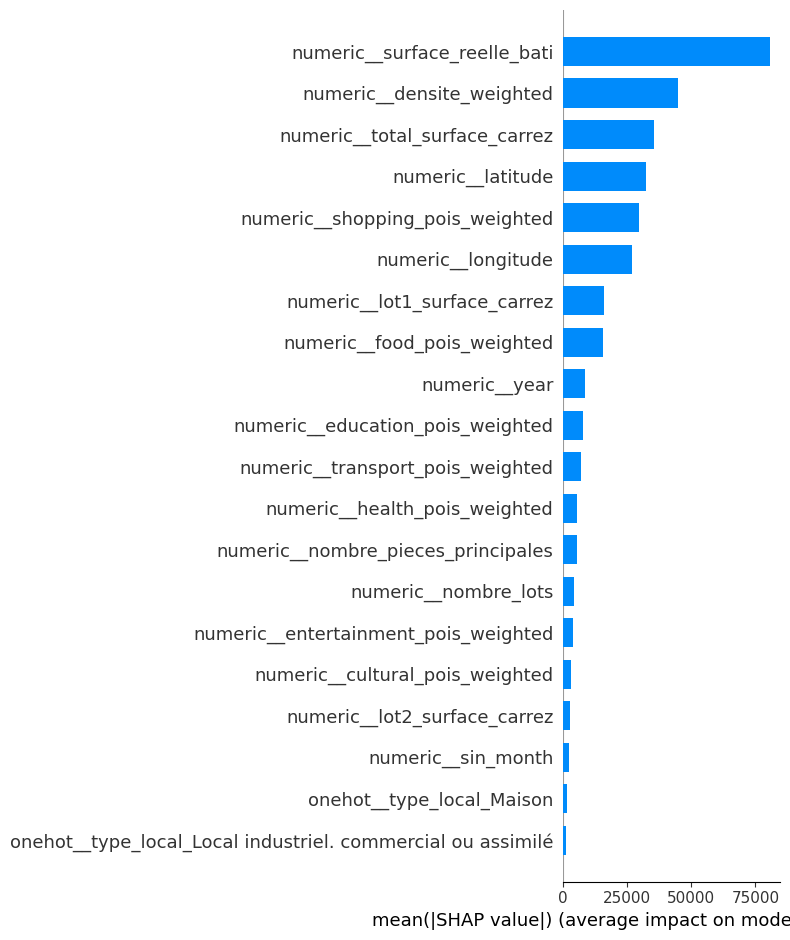

In [ ]:
import shap
import pandas as pd
new_columns = column_transformer.get_feature_names_out()
# Charger tes données
X_test = pd.DataFrame(df_test_features_transformed,columns =new_columns)

# Calculer les valeurs SHAP
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Visualiser les valeurs SHAP
shap.summary_plot(shap_values, X_test,plot_type="bar")


In [23]:
import lime
import lime.lime_tabular
X_test = pd.DataFrame(df_test_features_transformed,columns =new_columns)
explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_test.values, mode='regression', training_labels=df_test_target, feature_names=new_columns )
def predict_with_dmatrix(data):
    dmatrix_data = xgb.DMatrix(data)
    return xgb_model.predict(dmatrix_data)

# Utilisation de LIME pour expliquer une instance
exp = explainer_lime.explain_instance(X_test.iloc[0].values, predict_with_dmatrix,)
exp.show_in_notebook()

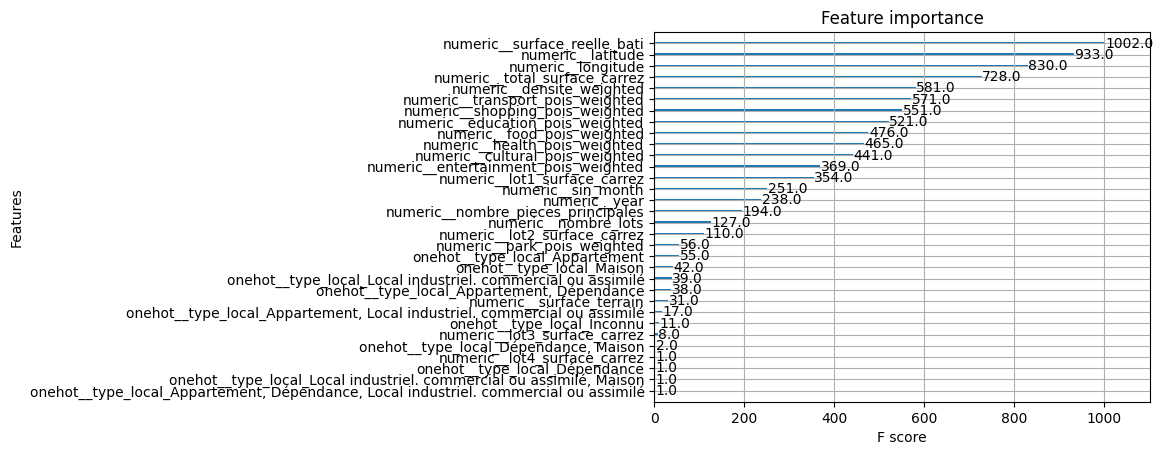

In [31]:
new_columns = list(new_columns)
xgb_model.feature_names = new_columns  # new_columns est la liste des noms des features
xgb.plot_importance(xgb_model)
plt.show()